# Linear Adiabatic State Preparation

Linear Adiabatic State Preparation is a quantum method that prepares a target state by slowly transforming an initial Hamiltonian into a final Hamiltonian. By starting in the ground state of an initial Hamiltonian and evolving gradually, the system ideally stays in the ground state, ultimately reaching the ground state of the target Hamiltonian. This method leverages the **adiabatic theorem**, which states that a quantum system will remain in its instantaneous ground state if the Hamiltonian changes slowly enough.

In this example, the Hamiltonian $H(t)$ is a **linear interpolation** between two Hamiltonians:

1. **Initial Hamiltonian, $ H_z $:** Encodes the starting state. Here, $ H_z = I \otimes Z + Z \otimes I $, which introduces interactions based on the $ Z $-basis of the qubits.
2. **Target Hamiltonian, $ H\_{xx} $:** Encodes the desired end state. Here, $ H\_{xx} = X \otimes X $, which induces transitions that align the final state along the $ X $-axis.

The time-dependent Hamiltonian is given by:

$$
H(t) = -(1 - \text{linear}) \cdot H_z - \text{linear} \cdot H_{xx}
$$

where $\text{linear} = 0.05 \cdot t$ provides a gradual increase over time. The `AnalogGate` with Hamiltonian $ H(t) $ simulates this gradual evolution.

In this setup, we prepare a **two-qubit system** with `AnalogCircuit`, evolving it first under the time-dependent Hamiltonian $ H(t) $ over 20 units of time, and then under $ H*{xx} $ for an additional 10 units. The final `measure()` captures the state, which ideally approximates the ground state of $ H*{xx} $, aligning with the target configuration.


In [1]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from oqd_analog_emulator.qutip_backend import QutipBackend
from oqd_core.backend.metric import Expectation
from oqd_core.backend.task import Task, TaskArgsAnalog
from oqd_core.interface.analog.operation import AnalogCircuit, AnalogGate
from oqd_core.interface.analog.operator import PauliI, PauliX, PauliY, PauliZ
from oqd_core.interface.math import MathStr

warnings.filterwarnings("ignore")

In [2]:
X, Y, Z, I = PauliX(), PauliY(), PauliZ(), PauliI()  # noqa: E741

In [3]:
Hxx = X @ X
Hz = I @ Z + Z @ I

linear = MathStr(string="0.05*t")

H = -(1 - linear) * Hz + -linear * Hxx

gate = AnalogGate(hamiltonian=H)

Gxx = AnalogGate(hamiltonian=Hxx)

In [4]:
n = 2  # number of qubits

circuit = AnalogCircuit()
circuit.evolve(gate=gate, duration=20)
circuit.evolve(gate=Gxx, duration=10)
circuit.measure()

In [5]:
args = TaskArgsAnalog(
    n_shots=1000,
    metrics={
        "Z": Expectation(operator=0.5 * (I @ Z + Z @ I)),
        "XX": Expectation(operator=X @ X),
    },
    dt=1e-2,
)

task = Task(program=circuit, args=args)

In [6]:
backend = QutipBackend()
results = backend.run(task=task);

[1/1] Cythonizing qtcoeff_be2b8a7b080282c382b3bc365b5cd7.pyx
running build_ext
building 'qtcoeff_be2b8a7b080282c382b3bc365b5cd7' extension
"C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.42.34433\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -Id:\work\Projects\equilux\.venv\Lib\site-packages\qutip\core\data -Id:\work\Projects\equilux\.venv\Lib\site-packages\numpy\core\include -Id:\work\Projects\equilux\.venv\include -IC:\Users\Salieri\AppData\Roaming\uv\python\cpython-3.12.9-windows-x86_64-none\include -IC:\Users\Salieri\AppData\Roaming\uv\python\cpython-3.12.9-windows-x86_64-none\Include "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.42.34433\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.42.34433\ATLMFC\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22621.0\ucrt" "-IC:\Program Fi

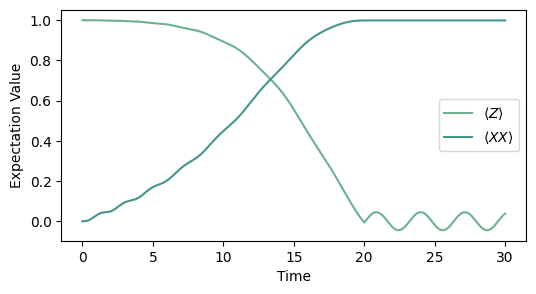

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[6, 3])
colors = sns.color_palette(palette="crest", n_colors=4)

for k, (name, metric) in enumerate(results.metrics.items()):
    ax.plot(results.times, metric, label=f"$\\langle {name} \\rangle$", color=colors[k])
ax.set(xlabel="Time", ylabel="Expectation Value")
ax.legend();

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


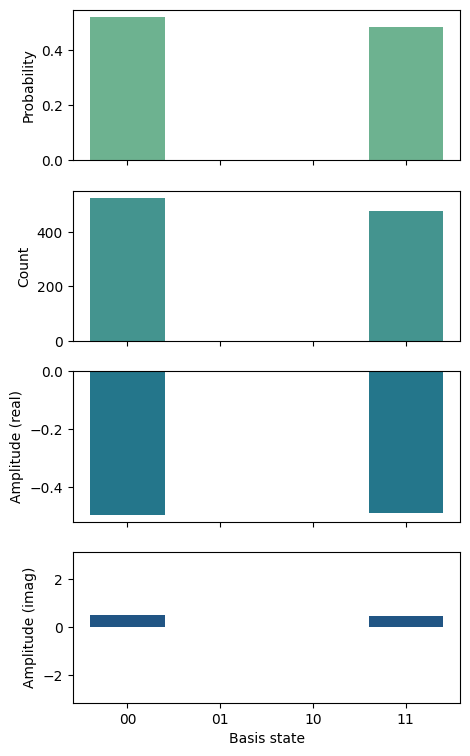

In [8]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[5, 9])

state = np.array([basis.real + 1j * basis.imag for basis in results.state])
bases = ["".join(bits) for bits in itertools.product("01", repeat=n)]
counts = {basis: results.counts.get(basis, 0) for basis in bases}

ax = axs[0]
ax.bar(x=bases, height=np.abs(state) ** 2, color=colors[0])
ax.set(ylabel="Probability")


ax = axs[1]
ax.bar(x=bases, height=list(counts.values()), color=colors[1])
ax.set(ylabel="Count")


ax = axs[2]
ax.bar(x=bases, height=state.real, color=colors[2])
ax.set(ylabel="Amplitude (real)")

ax = axs[3]
ax.bar(x=bases, height=state.imag, color=colors[3])
ax.set(xlabel="Basis state", ylabel="Amplitude (imag)", ylim=[-np.pi, np.pi]);